# Logistic Regression

In [151]:
import torch
import tqdm
import seaborn as sns
import matplotlib.pyplot  as plt
import os
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import random 
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [24]:
DATASET_SIZE = "xs"
DATASET_TYPE = "waveform"

DATASET_FOLDER = f"./data/{DATASET_TYPE}"

DATASET_NUM_SAMPLES_PER_SECOND = 8000
DATASET_NUM_CHANNELS = 1

DATASET_NAME = f"fma_{DATASET_SIZE}_resampled_{DATASET_NUM_SAMPLES_PER_SECOND}_rechanneled_{DATASET_NUM_CHANNELS}"

dataset_path = f"{DATASET_FOLDER}/{DATASET_NAME}"

In [ ]:
audio_path_list = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        file_audio_path = os.path.join(path, name)
        print(file_audio_path)

        if name != '.DS_Store':
            audio_path_list.append(file_audio_path)

audio_path_list = sorted(audio_path_list , reverse= True) 

In [ ]:
single_tensors = []
labels = []
for p in audio_path_list:
    single_tensors.append(torch.load(p))
    labels.append(p.split("/")[-2])


stacked_single_tensors = torch.cat(single_tensors).numpy()

In [115]:
data = pd.DataFrame(stacked_single_tensors)
data.insert(0, "Label", labels, True)

In [124]:
def train_test_split( dataset , perc_train , set_seed = 69):
    train = dataset.sample(frac= perc_train,random_state = set_seed )
    test  = dataset.drop(train.index)
    return (train , test )
#####   
train_dataset , test_dataset = train_test_split( data , perc_train = .85)

In [ ]:
X = train_dataset.iloc[: , 1:]      # ALL THE DATA POINTS
y = train_dataset.iloc[: , :1]      # ALL THE LABELS

std_slc = StandardScaler()          # STANDARDIZE

pca = decomposition.PCA()           # PCA

logistic_Reg = linear_model.LogisticRegression()    # LINEAR REGRESSION

### 
pipe = Pipeline(steps=[('std_slc', std_slc),
                ('pca', pca),
                ('logistic_Reg', logistic_Reg)])


n_components = list(range( int(.01 * X.shape[0]) ,  int(.25 * X.shape[0]) , 1))    # NUMBER OF PCA WE TEST
# WE TRIED DIFFERENTS COMBINATIONS AND WE ENDED UP DISCOVERING THAT FEW PRINCIPAL COMPONENTS WERE ENOUGH
# WE NOW TEST ONLY ON THE FIRST 25% OF THE POSSIBLE NUMBER OF PC's.

C = [2., 20.]      # NUMBER OF C VALUE WE TEST

penalty = ['l1', 'l2']    # PENALTY WE TEST

# COMBINE ALL IN A DICTIONARY
parameters = dict(pca__n_components=n_components,
                    logistic_Reg__C=C,
                    logistic_Reg__penalty=penalty)


In [ ]:
### RUN THE KFOLD CROSS VALIDATION TO DISCOVER THE BEST HYPERPARAMETERS
clf = GridSearchCV(pipe, parameters, n_jobs=2, verbose=3, cv=3)
clf.fit(X, y)

In [ ]:
print('Best Penalty:', clf.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: l2
Best C: 2.0
Best Number Of Components: 52

LogisticRegression(C=2.0)


In [ ]:
# WE DON'T KNOW WHY IS HERE
#CV_result = cross_val_score(clf , X , y , cv = 3 , n_jobs=2, verbose=3)

## Run the Logistcics regression with the best hyperparameters

In [ ]:
X_train = train_dataset.iloc[: , 1:]      # ALL THE DATA POINTS for the training set 
y_train = train_dataset.iloc[: , :1]      # ALL THE LABELSfor the training set 

X_test =  test_dataset.iloc[: , 1:]       # ALL THE DATA POINTS for the test set 
y_test =  test_dataset.iloc[: , :1]       # ALL THE LABELS for the test set

# [TODO]  do not arcoding but with the best hyperparameter

pca = PCA(n_components= 11)               # PCA with the best number of components
X_train_pca =  pd.DataFrame(pca.fit_transform(X_train))   # Transform the train dataset in pc
X_test_pca  =  pd.DataFrame(pca.fit_transform(X_test ))   # Transform the test  dataset in pc

### RUN THE LOGISTIC REGRESSION

logistic = LogisticRegression(penalty= 'l2'  , C = 2)
logistic.fit( X_train_pca  , y_train )

### TEST THE MODEL
LogisticPredictions = logistic.predict( X_test_pca )

In [143]:
Logistic_Accuracy = logistic.score(  X_test_pca , y_test ) 
Logistic_Accuracy ="{: .0%}".format(Logistic_Accuracy)
print(f"The accuracy of the logistic model is:{Logistic_Accuracy}")

The accuracy of the logistic model is: 21%


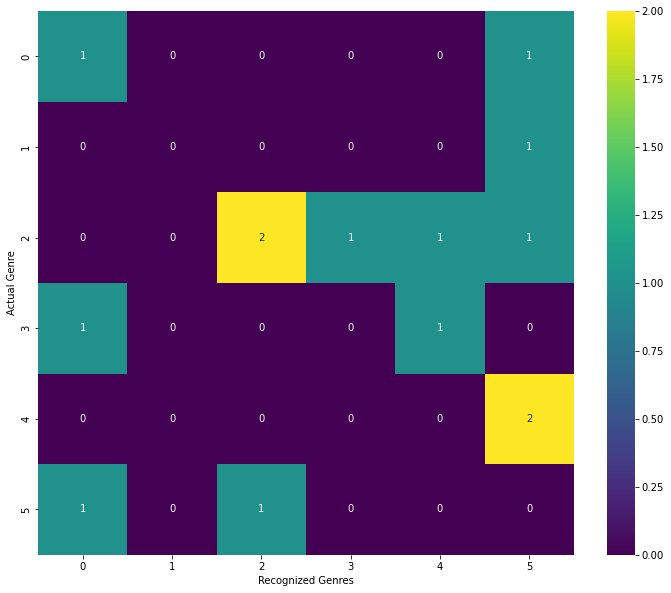

In [159]:
### CONFUSION MATRIX
confusion = metrics.confusion_matrix( y_test , LogisticPredictions)
plt.figure(figsize=(12,10))
sns.heatmap(confusion , annot= True , fmt = 'd' , cmap= "viridis")
plt.xlabel("Recognized Genres")
plt.ylabel("Actual Genre")
plt.show()

In [ ]:

 
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_features.shape)

In [ ]:
import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (12,8)

fig, ax = plt.subplots()
xi = np.arange(1, 61, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='red')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 61, step=1), rotation = 90) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.7, color='darkgreen', linestyle='--')
plt.text(1.1, 1, '70% cut-off threshold', color = 'darkgreen', fontsize=16)

ax.grid()
plt.tight_layout()
plt.show()

In [36]:
test_dataset.iloc[: , 1:]

,0,1,2,3,4,5,6,7,8,9,...,237990,237991,237992,237993,237994,237995,237996,237997,237998,237999
9,0.008234,0.010684,0.003508,0.002686,-0.001900,0.001159,-0.000374,-0.003358,0.003079,-0.001310,...,-0.203883,-0.437538,-0.513192,-0.509520,-0.464054,-0.262243,0.100966,0.051868,0.126681,0.202008
20,0.000242,0.000148,0.000029,0.000122,0.000174,-0.000082,-0.000124,0.000156,-0.000041,-0.000223,...,-0.262216,-0.189099,-0.089163,-0.122821,-0.168169,-0.136992,0.008826,0.082147,0.049861,0.062775
22,0.004516,0.002586,-0.000504,0.002324,0.001361,0.001164,0.001756,0.002061,0.001286,-0.001631,...,-0.154083,-0.204206,-0.137308,-0.143353,-0.134408,-0.125974,-0.023337,-0.002398,-0.081676,-0.022399
49,0.001199,0.001048,0.003401,0.001240,0.000462,0.000892,-0.000196,-0.000868,0.001279,0.001767,...,0.015631,-0.011225,-0.002610,0.003677,0.002981,-0.013040,-0.019982,0.006720,0.035207,0.087214
54,0.005291,0.004534,-0.002246,-0.006056,-0.010251,-0.008787,-0.002304,0.002260,0.001732,0.003227,...,-1.013173,-0.997653,-0.932473,-0.875366,-0.887953,-0.819201,-0.735276,-0.657150,-0.716523,-0.684720
55,0.004482,0.003281,-0.000192,-0.002675,-0.000145,0.005437,0.002224,-0.003226,-0.003051,-0.000294,...,-0.330977,-0.526317,-0.698106,-0.871481,-1.000397,-1.104575,-1.143645,-1.102311,-1.077322,-1.000269
56,0.006836,0.003612,0.009416,0.010575,0.010387,0.008242,0.006145,0.006070,0.004588,0.004461,...,0.437255,0.558165,0.561081,0.572451,0.544912,0.429185,0.369773,0.284628,0.234021,0.208999
73,-0.000080,-0.000053,-0.000033,0.000016,0.000055,0.000064,-0.000012,-0.000041,-0.000007,-0.000029,...,0.013216,0.006755,0.002225,0.000341,-0.000879,-0.002471,-0.007369,-0.014305,-0.018592,-0.019696
75,0.017488,-0.009679,-0.018584,-0.017172,-0.025965,-0.002325,-0.012070,-0.021997,0.048340,0.060432,...,-0.033159,0.018963,0.024293,-0.019560,0.004781,-0.004360,0.031849,0.034502,-0.027264,0.014638


In [47]:
pca = PCA(n_components= 7  )
dataset_pca = pca.fit_transform(train_dataset.iloc[: , 1:])


In [48]:
label = train_dataset.iloc[ : , :1 ]

In [107]:
labels_train =[]
for x in label.values:
    labels_train.append(_label_from_str_to_one_hot(x[0]))
    

In [112]:
dataset_pca = pd.DataFrame(dataset_pca)

In [50]:
pca_test = PCA(n_components= 52 )
test_dataset_pca = pca.fit_transform(test_dataset.iloc[: , 1:])

In [78]:
lab_test = pd.get_dummies(test_dataset.iloc[ : , :1 ])

In [79]:
lab_test

,Label_Electronic,Label_Folk,Label_Hip-Hop,Label_Pop,Label_Rock
9,0,0,0,0,1
20,0,0,0,1,0
22,0,0,0,1,0
49,0,0,1,0,0
54,0,0,1,0,0
55,0,0,1,0,0
56,0,0,1,0,0
73,0,1,0,0,0
75,1,0,0,0,0


In [58]:
logistic.predict(test_dataset_pca)


array(['Electronic', 'Jazz', 'Jazz', 'Hip-Hop', 'Hip-Hop', 'Electronic',
       'Jazz', 'Jazz', 'Rock'], dtype=object)

In [98]:
def _label_from_str_to_one_hot(label_str: str): 

    if label_str == "Pop":
        return [1, 0, 0, 0, 0, 0]
    
    if label_str == "Hip-Hop":
        return [0, 1, 0, 0, 0, 0]
    
    if label_str == "Electronic":
        return [0, 0, 1, 0, 0, 0]
    
    if label_str == "Rock":
        return [0, 0, 0, 1, 0, 0]

    if label_str == "Folk":
        return [0, 0, 0, 0, 1, 0]

    if label_str == "Jazz":
        return [0, 0, 0, 0, 0, 1]

In [104]:
results 

    

[[0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0]]

In [114]:

LogisticPredictions = logistic.predict( test_dataset_pca )
results = []
for x in LogisticPredictions:
    results.append(_label_from_str_to_one_hot(x))

lab_test = []
for x in label_test.values:
    lab_test.append(_label_from_str_to_one_hot(x[0]))


Logistic_Accuracy = logistic.score(  results , lab_test ) 

ValueError: X has 6 features, but LogisticRegression is expecting 7 features as input.

In [95]:
LogisticPredictions

array(['Electronic', 'Jazz', 'Jazz', 'Hip-Hop', 'Hip-Hop', 'Electronic',
       'Jazz', 'Jazz', 'Rock'], dtype=object)

In [72]:
lab_test = []
for x in label_test.values:
    lab_test.append(x[0])

In [75]:
lab_test

['Rock',
 'Pop',
 'Pop',
 'Hip-Hop',
 'Hip-Hop',
 'Hip-Hop',
 'Hip-Hop',
 'Folk',
 'Electronic']

ValueError: could not convert string to float: 'Electronic'

In [ ]:
Logistic_Accuracy

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix( Y_test , LogisticPredictions , labels = None, sample_weight=None, normalize=None)

In [ ]:
from sklearn.model_selection import KFold
key_fold = KFold( n_splits=4 ) 
key_fold.get_n_splits(X_train)

In [ ]:
import pandas as pd
df = pd.DataFrame(stacked_single_tensors)
X = df.iloc[:,:-1]
y = labels


In [ ]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import utils
from tqdm import tqdm
set.seed(69)


X = df.iloc[:,:-1]

#convert y values to categorical values

y = pd.DataFrame(labels)

#Implementing cross validation

k = 3
kf = KFold(n_splits=k, random_state= None , shuffle= True )
model = LogisticRegression()

acc_score = []

for train_index , test_index in tqdm( kf.split(X) ):

    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]


    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score( pred_values , y_test)
    acc_score.append(acc)

avg_acc_score = sum(acc_score)/k
